{'211206/0600': {'data': array([[9.77700000e+02, 6.88520287e+00, 2.91050000e+02, 2.00290000e+02,
        2.76590000e+02, 2.76612000e+02],
       [9.74800000e+02, 6.88223232e+00, 2.91350000e+02, 2.24410000e+02,
        2.76690000e+02, 2.76716000e+02],
       [9.69500000e+02, 6.87678047e+00, 2.90980000e+02, 2.68650000e+02,
        2.76190000e+02, 2.76217000e+02],
       [9.60300000e+02, 6.86724574e+00, 2.90420000e+02, 3.45800000e+02,
        2.75190000e+02, 2.75214000e+02],
       [9.46800000e+02, 6.85308788e+00, 2.90060000e+02, 4.59910000e+02,
        2.74090000e+02, 2.74105000e+02],
       [9.29500000e+02, 6.83464681e+00, 2.90290000e+02, 6.08170000e+02,
        2.73890000e+02, 2.73906000e+02],
       [9.08800000e+02, 6.81212505e+00, 2.92150000e+02, 7.89210000e+02,
        2.74090000e+02, 2.74116000e+02],
       [8.86300000e+02, 6.78705549e+00, 2.94510000e+02, 9.90700000e+02,
        2.73790000e+02, 2.73812000e+02],
       [8.61900000e+02, 6.75913925e+00, 2.96400000e+02, 1.21483000e+03,

C:\Users\tjtur\AppData\Local\Temp/ipykernel_12604/2850470823.py:53: RuntimeWarning: divide by zero encountered in log
  log_p = np.log(pressure)


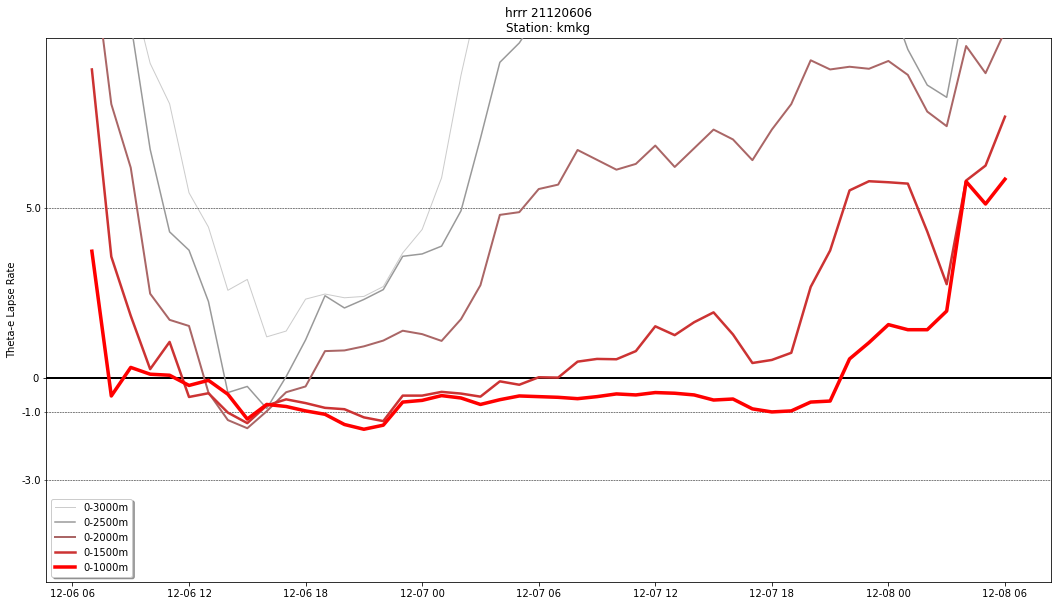

In [16]:
from metpy.units import units
import numpy as np
from metpy import calc
from scipy import interpolate
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import re

master = {}

model = 'hrrr'
station = 'kmkg'
runtime = '21120606'
figure_title = "{} {}\nStation: {}".format(model,runtime,station)
file_path = f'C:\\Users\\Public\\Bufkit\\Data\\Archive\\{runtime}.{model}_{station}.buf'
fin = open(file_path,'r')

data = fin.read()
fin.close()

def calc_thetae(p,t,dp=None):
    temperature = units.Quantity(t - 273.15, 'degC')
    pressure = units.Quantity(p, 'hPa')
    theta = calc.potential_temperature(pressure,temperature)

    if dp is not None:
        dewpoint = units.Quantity(dp, 'degC')
        theta_e = calc.equivalent_potential_temperature(pressure,temperature,dewpoint)
        return round(theta_e.magnitude, 3), round(theta.magnitude, 3)
    else:
        return -9999, round(theta.magnitude, 3)

def parse_forecast_hour_data(dat):
    """
    parses data for each hour
    Returns:
    list of 
    """
    this_array = []

    lines = dat.split("\n")
    #print(lines)
    fh = lines[0].split(" ")[-1]
    stn_id = lines[0].split(" ")[-4]
    for line in lines:
        this_row = []
        vals = line.split(" ")
        if line[:1].isdigit() and '/' not in line:
            if len(vals) > 2:
                pressure = float(vals[0])
                log_p = np.log(pressure)
                try:
                    temperature = float(vals[1])
                except:
                    temperature = 999
                theta_e = float(vals[4])
            elif len(vals) == 2:
                height = float(vals[1])
                ignore,theta = calc_thetae(pressure,temperature,None)
                this_row = [pressure, log_p, theta_e, height, temperature + 273.15, theta + 273.15]
                #print(this_row)
                this_array.append(this_row)

    master[fh] = {'data':np.array(this_array)}
    return master, stn_id

def get_value(line,n):
    """
    Parameters:
        line: string with spaces
        n: the index of the list created by splitting spaces
    """
    values = line.split(" ")
    return values[n]

def parse_sfc_data(dat,stn_id):
    surface = {}
    fhrs = dat.split(stn_id)
    for h in range(3,len(fhrs)):
        try:
            vals = fhrs[h].split("\n")
            dt = get_value(vals[0],1)
            sfc_pressure = float(get_value(vals[0],3))
            sfc_temperature = float(get_value(vals[2],5)) + 273.15
            sfc_dewpoint = float(get_value(vals[5],0))
            sfc_theta_e, sfc_theta = calc_thetae(sfc_pressure,sfc_temperature,sfc_dewpoint)
            master[dt].update({"surface_temperature":sfc_temperature, "surface_theta_e":sfc_theta_e, "surface_theta":sfc_theta })
        except:
            pass

    return master
    

def converge(reference, levels, values):
    """
        Finds the closest model vertical levels above and below a reference height, then performs
        an interpolation between those levels to estimate a value at the reference height.

        Parameters
        ----------
              reference : integer
                          Desired height (m AGL) at which to make the calculation
                 levels : list of integers
                          Heights (m AGL) corresponding to the available bufkit model levels.

        Returns
        -------
                  final : float
                          calculated interpolated value at the reference height.
    """
    for n in range(0,len(levels)):
        check_low = levels[n]
        check_high = levels[n+1]
        if check_low <= reference and check_high >= reference:
            #print(check_low,values[n],check_high,values[n+1],reference)
            fraction = (reference - check_low)/(check_high - check_low)
            slope = values[n + 1] - values[n]
            final = values[n] + fraction*slope
            return final
        else:
            pass
    
    return
    
def interpol(level,x,y):
    f = interpolate.interp1d(x, y, assume_sorted = False)
    val = np.interp(level, f.x, f.y)
    return val

def clean_difference(v1,v2):
    difference = v1 - v2
    return round(difference,2)


fhrs = data.split("STID = ")
for h in range(1,len(fhrs)):
    dat = fhrs[h]
    master, stn_id = parse_forecast_hour_data(dat)


surface = parse_sfc_data(fhrs[-1],stn_id)
print(surface)

plotting = []

for key in master:
    # 211203/1900
    try:
        dt = datetime.strptime(key, '%y%m%d/%H%M')
        dat = master[key]['data']
        sfc_temperature = master[key]['surface_temperature']
        sfc_theta_e = master[key]['surface_theta_e']
        pressures = dat[:,0]
        logs = dat[:,1]
        thetaes = dat[:,2]
        heights = dat[:,3]
        temperatures = dat[:,4]

        temperature_h8 = interpol(np.log(850.0), logs, temperatures)
        delta_t = clean_difference(temperature_h8,sfc_temperature)

        theta_e_1000 = converge(1000.0, heights, thetaes)
        theta_e_1500 = converge(1500.0, heights, thetaes)
        theta_e_2000 = converge(2000.0, heights, thetaes)
        theta_e_2500 = converge(2500.0, heights, thetaes)
        theta_e_3000 = converge(3000.0, heights, thetaes)
        dte_1000 = -clean_difference(sfc_theta_e,theta_e_1000)
        dte_1500 = -clean_difference(sfc_theta_e,theta_e_1500)
        dte_2000 = -clean_difference(sfc_theta_e,theta_e_2000)
        dte_2500 = -clean_difference(sfc_theta_e,theta_e_2500)
        dte_3000 = -clean_difference(sfc_theta_e,theta_e_3000)        

        this = [dt, delta_t, dte_1000, dte_1500, dte_2000, dte_2500, dte_3000]

        plotting.append(this)
    except:
        pass


df = pd.DataFrame(data=plotting, columns=["dt", "delta_t","dte_1000", "dte_1500", "dte_2000",  "dte_2500", "dte_3000"])
df.set_index('dt', inplace=True)

fig = plt.figure(figsize=(18,10))

ax1 = fig.add_subplot(111)
ax1.plot(df["dte_3000"], color='#cccccc', linewidth=1, label="0-3000m", zorder=2)
ax1.plot(df["dte_2500"], color='#999999', linewidth=1.5, label="0-2500m", zorder=3)
ax1.plot(df["dte_2000"], color='#aa6666', linewidth=2, label="0-2000m", zorder=4)
ax1.plot(df["dte_1500"], color='#cc3333', linewidth=2.5, label="0-1500m", zorder=5)
ax1.plot(df["dte_1000"], color='#ff0000', linewidth=3.5, label="0-1000m", zorder=6)

plt.ylim(-6, 10)
ax1.set_yticks([0.0], minor=False)
ax1.set_yticks([-1.0,-3.0,5.0], minor=True)
ax1.yaxis.grid(True, which='major')
ax1.grid(color='k', linestyle='-', axis='y', linewidth=2, which='major', zorder=7)
ax1.grid(color='k', linestyle='--', axis='y', linewidth=0.5, which='minor', zorder=7)
ax1.yaxis.set_minor_formatter(FormatStrFormatter("%.1f"))
ax1.set_axisbelow(False)
plt.ylabel('Theta-e Lapse Rate')
plt.title(figure_title)


#ax1.yaxis.grid(True, which='minor')
ax1.legend(shadow=True, fancybox=True)
#df.plot()
